In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import norm, skew 

def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) 

## 查看數據(訓練集、測試集)

In [2]:
train = pd.read_csv('train.csv')
print(train.shape)
train.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
test = pd.read_csv('test.csv')
print(test.shape)
test.head()

(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### 刪除ID
#### 因為Id不具參考價值

In [4]:
train = train.drop('Id', axis=1)
test = test.drop('Id', axis=1)

print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


### 查看SalePrice
#### Saleprice是我們要預測的目標且是個變數

mu = 180921.20, sigma = 79415.29


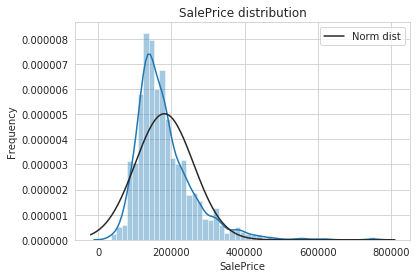

In [5]:
(mu,sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f}, sigma = {:.2f}'.format(mu,sigma))

sns.set_style('whitegrid')
sns.distplot(train['SalePrice'], fit=norm)
mp.legend(['Norm dist'], loc='best')
mp.ylabel('Frequency')
mp.title('SalePrice distribution')
mp.show()

#### 由圖可知SalePrice偏右，對機器學習的模型計算效果不佳，所以透過log1p: log(1+x) 修正偏移度。

mu = 12.02, sigma = 0.40


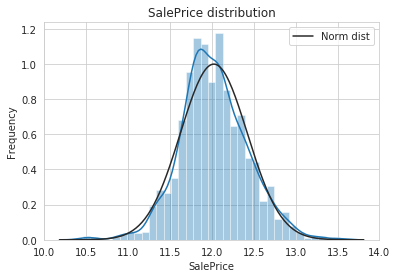

In [6]:
# 使用log1p
train['SalePrice'] = np.log1p(train['SalePrice'])

(mu,sigma) = norm.fit(train['SalePrice'])
print('mu = {:.2f}, sigma = {:.2f}'.format(mu,sigma))

sns.set_style('whitegrid')
sns.distplot(train['SalePrice'], fit=norm)
mp.legend(['Norm dist'], loc='best')
mp.ylabel('Frequency')
mp.title('SalePrice distribution')
mp.show()

#### 經過log1p轉換, SalePrice為常態分佈

### 查看離散值
#### 根據競賽內文提到GrLivArea與Saleprice含有離散值 
There are five observations that an instructor may wish to remove from the data set before giving
it to students (a plot of SALE PRICE versus GR LIV AREA will quickly indicate these
points). Three of them are true outliers (Partial Sales that likely don’t represent actual
market values) and two of them are simply unusual sales (very large houses priced
relatively appropriately). I would recommend removing any houses with more than
4000 square feet from the data set (which eliminates these five unusual observations)
before assigning it to students.

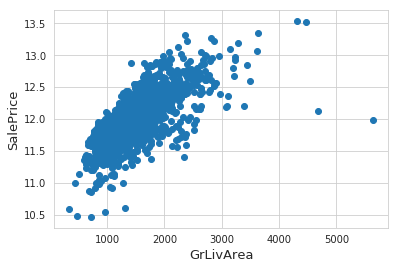

In [7]:
fig, ax = mp.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
mp.xlabel('GrLivArea', fontsize=13)
mp.ylabel('SalePrice', fontsize=13)
mp.show()

#### 從圖可以發現右下有兩個GrLivArea面積偏大,但價格偏低, 可以確認這兩個點為離散值

In [8]:
# 刪除離散值
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

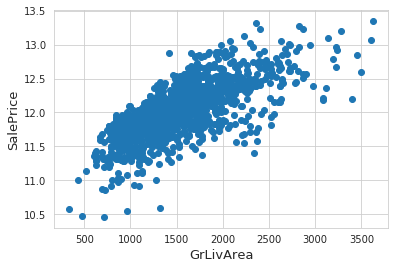

In [9]:
# 刪除離散值後
fig, ax = mp.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
mp.xlabel('GrLivArea', fontsize=13)
mp.ylabel('SalePrice', fontsize=13)
mp.show()

## 特徵工程

In [10]:
ntrain = train.shape[0]
ntest = test.shape[0]
train_y = train.SalePrice.values
# 將訓練集和測試集合併
d_all = pd.concat([train, test]).reset_index(drop=True)
d_all = d_all.drop(['SalePrice'], axis=1)
d_all.shape

(2915, 79)

### 視覺化定量的特徵屬性與SalePrice的關係

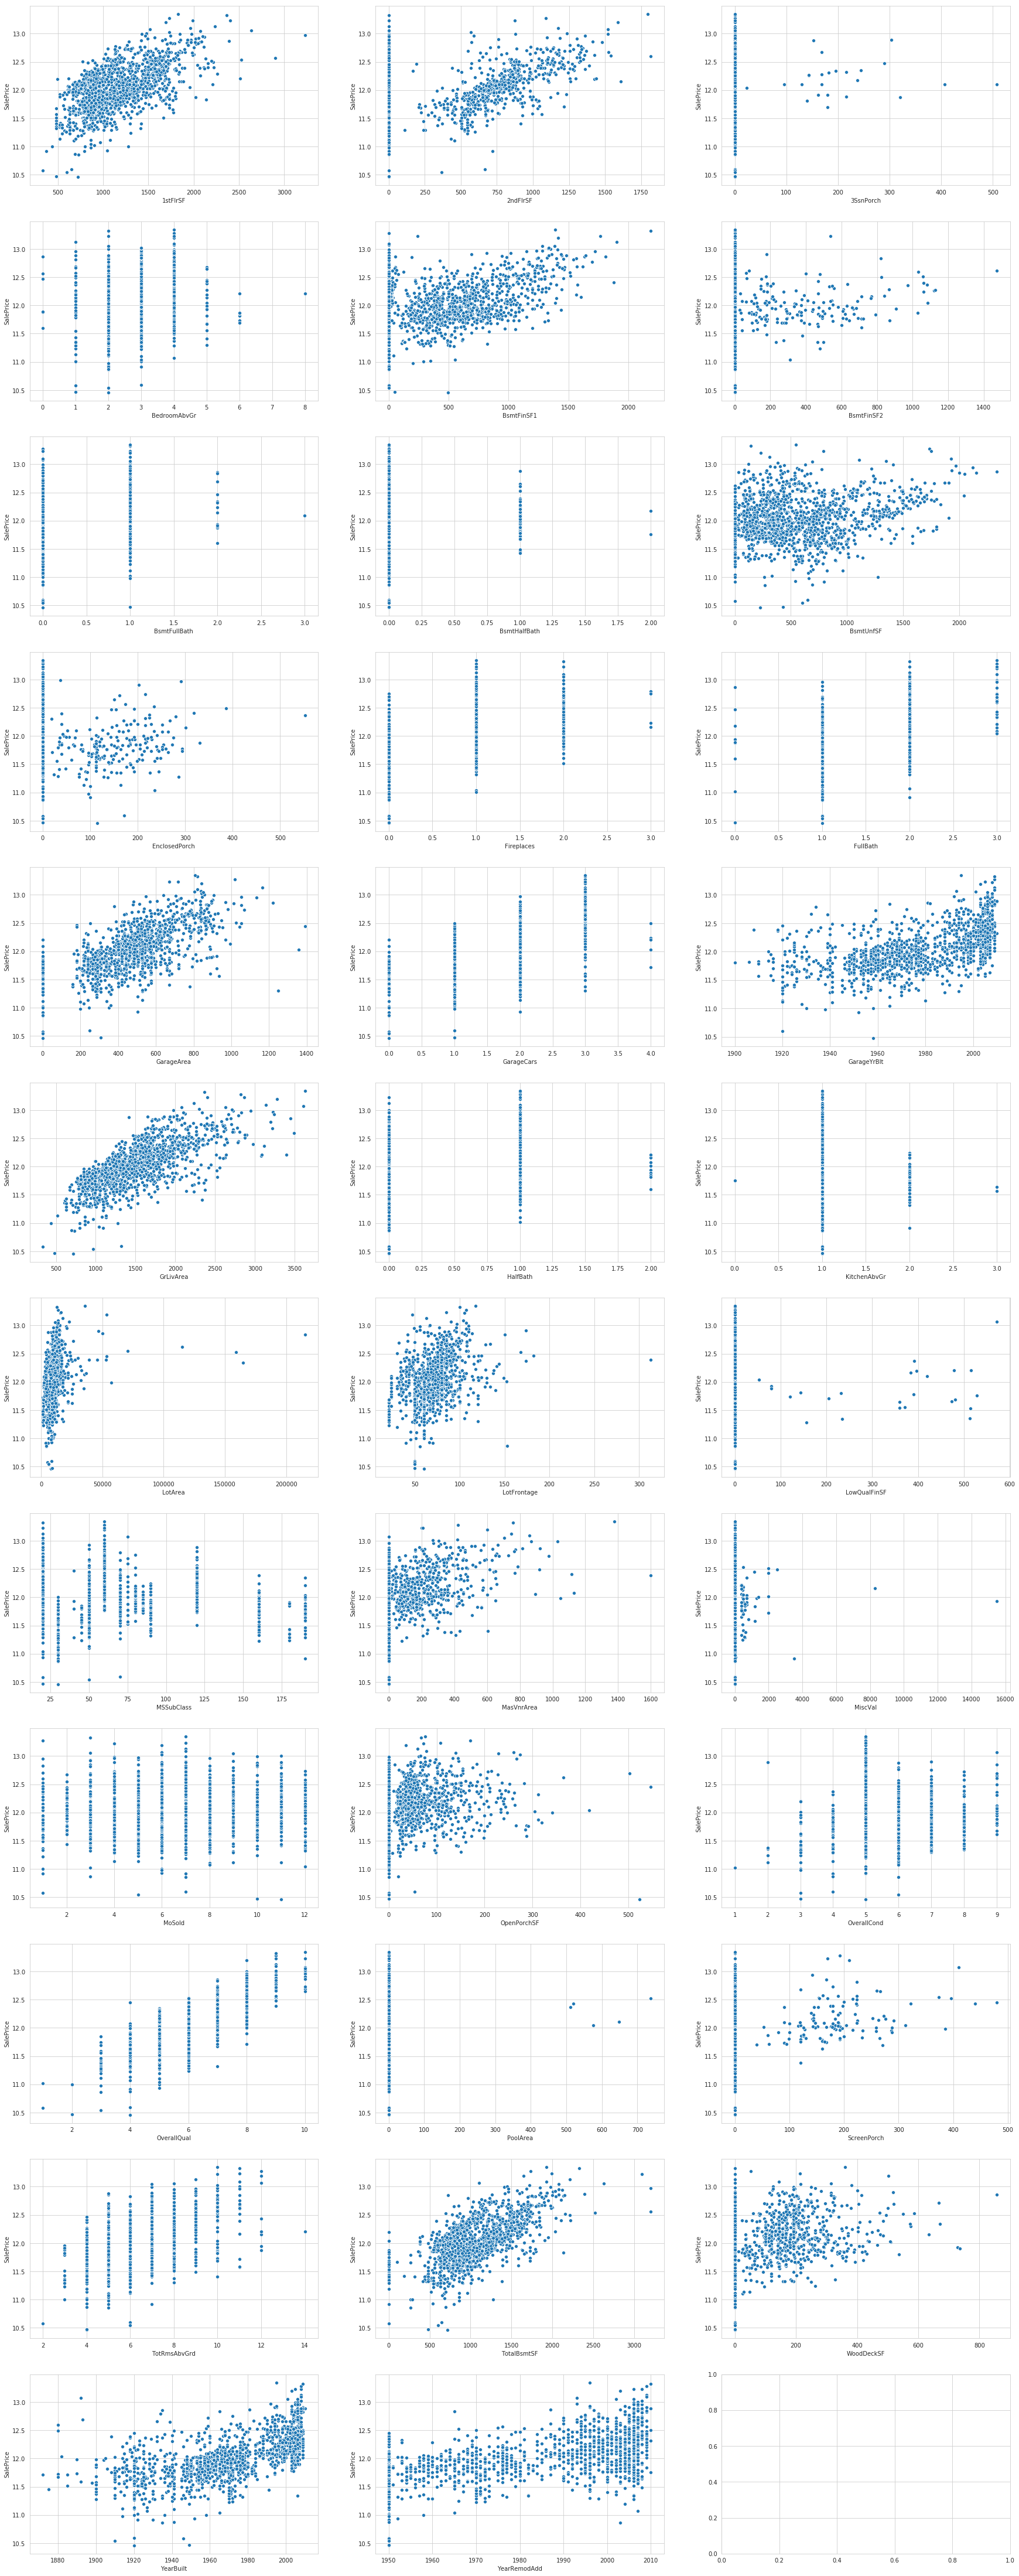

In [11]:
quan = d_all.dtypes[d_all.dtypes != "object"].index

fig, axs = mp.subplots(12, 3, figsize=(30,80))
for i in range(1, len(quan)):
    data = quan[i-1]
    mp.subplot(12, 3, i)
    sns.scatterplot(x=train[data], y=train['SalePrice'])
mp.show()

### 查看所有屬性的彼此關聯性

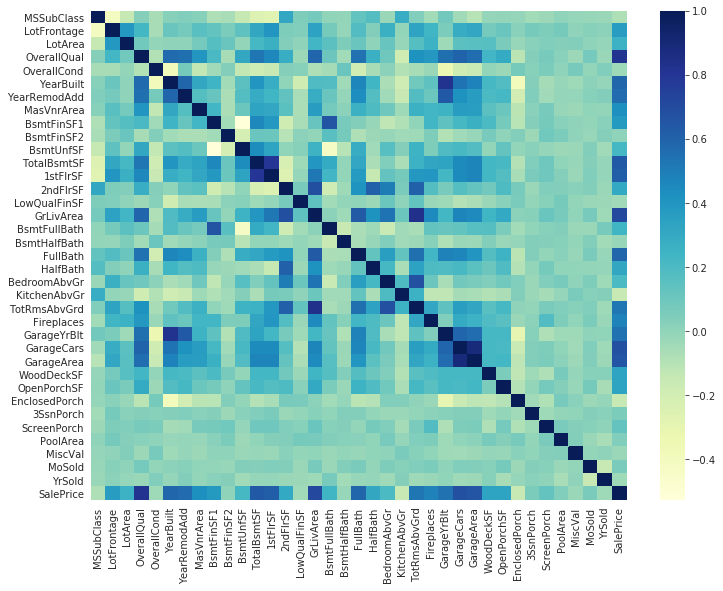

In [12]:
# 數據相關性
corr = train.corr()
sns.set_style('whitegrid')
mp.subplots(figsize=(12,9))
sns.heatmap(corr, cmap='YlGnBu')
mp.show()

#### 顏色越深代表關聯性越高

### 查看缺失值

In [13]:
d_all_na = (d_all.isnull().sum() / len(d_all)) * 100
d_all_na = d_all_na.drop(d_all_na[d_all_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio': d_all_na})
missing_data

,Missing Ratio
PoolQC,99.726
MiscFeature,96.398
Alley,93.208
Fence,80.446
FireplaceQu,48.714
LotFrontage,16.672
GarageQual,5.455
GarageCond,5.455
GarageFinish,5.455
GarageYrBlt,5.455


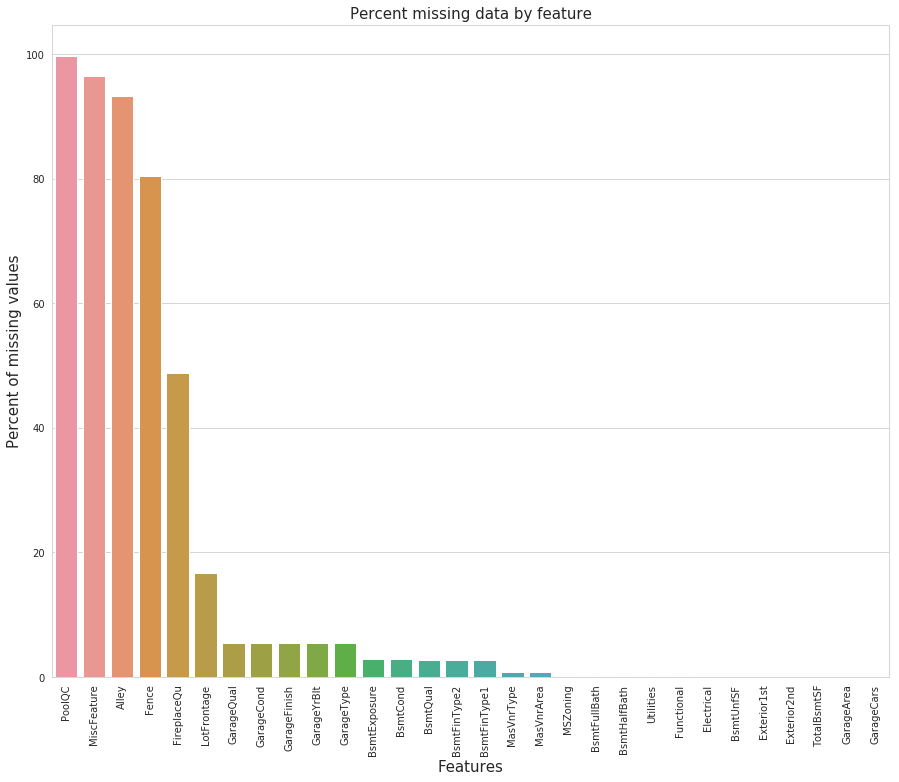

In [14]:
fig, ax = mp.subplots(figsize=(15,12))
mp.xticks(rotation='90')
sns.barplot(x=d_all_na.index, y=d_all_na)
mp.xlabel('Features', fontsize=15)
mp.ylabel('Percent of missing values', fontsize=15)
mp.title('Percent missing data by feature', fontsize=15)
mp.show()

#### 從圖表中可得知"PoolQC"缺失值最多, 根據資料描述的文檔可以確認PoolQC的缺失是因為該房子並沒游泳池。

### 填補缺失值

In [15]:
# NA = 沒有游泳池
d_all['PoolQC'] = d_all['PoolQC'].fillna('None')
# na = no misc feature
d_all['MiscFeature'] = d_all['MiscFeature'].fillna('None')
# NA = No alley access
d_all['Alley'] = d_all['Alley'].fillna('None')
# NA = No Fence
d_all['Fence'] = d_all['Fence'].fillna('None')
# NA = No Fireplace
d_all['FireplaceQu'] = d_all['FireplaceQu'].fillna('None')
# 當某條街道連接到不同的房屋,可以歸屬於同一區
# 所以使用neighborhood來區分LotFortage, 並取LotFortage中位數填補缺失值
d_all['LotFrontage'] = d_all.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# NA = No Garage == No car in Garage
Garage = ['GarageYrBlt', 'GarageCars', 'GarageArea']
for i in Garage:
	d_all[i] = d_all[i].fillna(0)

# NA = No Garage
Garage2 = ['GarageQual', 'GarageFinish', 'GarageCond', 'GarageType']
for i in Garage2:
	d_all[i] = d_all[i].fillna('None')

# NA = No Basement
Basement = ['BsmtCond','BsmtExposure', "BsmtQual", "BsmtFinType2", "BsmtFinType1"]
for i in Basement:
	d_all[i] = d_all[i].fillna('None')

Basement2 = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']
for i in Basement2:
	d_all[i] = d_all[i].fillna(0)

# NA = None
d_all['MasVnrType'] = d_all['MasVnrType'].fillna('None')
d_all['MasVnrArea'] = d_all['MasVnrArea'].fillna(0)

# 用多數的值來填補缺失值
d_all['MSZoning'] = d_all['MSZoning'].fillna(d_all['MSZoning'].mode()[0])

# Utilities 大部分都為ALLPub, 對計算模型效果不大, 故刪除此欄位
d_all = d_all.drop(['Utilities'], axis=1)

# NA = Assume typical unless deductions are warranted
d_all['Functional'] = d_all['Functional'].fillna('Typ')

# Electrical: 大部分值為SBrkr, 因為只有一筆, 所以用眾數將缺失值補上
d_all['Electrical'] = d_all['Electrical'].fillna(d_all['Electrical'].mode()[0])

d_all['KitchenQual'] = d_all['KitchenQual'].fillna(d_all['KitchenQual'].mode()[0])

Exterior = ['Exterior2nd', 'Exterior1st']
for i in Exterior:
	d_all[i] = d_all[i].fillna(d_all[i].mode()[0])

d_all['SaleType'] = d_all['SaleType'].fillna(d_all['SaleType'].mode()[0])

d_all['MSSubClass'] = d_all['MSSubClass'].fillna('None')

# 確認是否還有缺失值
d_all_na = (d_all.isnull().sum() / len(d_all)) * 100
d_all_na = d_all_na.drop(d_all_na[d_all_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio': d_all_na})
missing_data

,Missing Ratio


#### 已無缺失值

In [16]:
# 將由數值代替文字的屬性轉變成字符串
d_all['MSSubClass'] = d_all['MSSubClass'].apply(str)
d_all['OverallCond'] = d_all['OverallCond'].astype(str)
d_all['YrSold'] = d_all['YrSold'].astype(str)
d_all['MoSold'] = d_all['MoSold'].astype(str)

In [17]:
from sklearn.preprocessing import LabelEncoder
# 將字符串使用Lebelencoder轉換
cols = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold']

for col in cols:
    encoder = LabelEncoder()
    encoder.fit(list(d_all[col].values))
    d_all[col] = encoder.transform(list(d_all[col].values))
d_all.shape

(2915, 78)

In [18]:
# 新增新的屬性(將1樓坪數、2樓坪數和地下室坪數相加)
d_all['TotalSF'] = d_all['1stFlrSF'] + d_all['2ndFlrSF'] + d_all['TotalBsmtSF']

In [20]:
# 查找定量的偏移度
quan = d_all.dtypes[d_all.dtypes != "object"].index
skew_features = d_all[quan].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew':skew_features})
skewness

,Skew
MiscVal,21.932
PoolArea,18.702
LotArea,13.124
LowQualFinSF,12.080
3SsnPorch,11.368
LandSlope,4.971
KitchenAbvGr,4.299
BsmtFinSF2,4.143
EnclosedPorch,4.001
ScreenPorch,3.944


In [21]:
# 將偏移度大於0.5的屬性, 使用log1p轉換
skewness = skewness[abs(skewness) > 0.5]
print(skewness.shape[0])
skew_features = skewness.index
d_all[skew_features] = np.log1p(d_all[skew_features])

59


In [22]:
# 獨熱編碼
d_all = pd.get_dummies(d_all)

In [23]:
# 拆分新的訓練集和測試集
train = d_all[:ntrain]
test = d_all[ntrain:]
print(train.shape)
print(test.shape)

(1456, 220)
(1459, 220)


In [24]:
# 設置模型
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsCV, ElasticNetCV, Ridge, RidgeCV 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [25]:
# 設置交叉驗證
kf = KFold(5, shuffle=True, random_state=42).get_n_splits(train.values)

def rmsle_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train.values, train_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

scores = []
models_name = []

### Lasso Regression
#### 因數據中含有離散值, 所以使用RobustScaler

In [26]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0002))
# lasso = LassoLarsCV() # 透過LassoLarsCV找出最佳的alpha值
# lasso.fit(train, train_y)
# # print('最佳的alpha：',lasso.alpha_) 
score = rmsle_cv(lasso)
scores.append(score.mean())
models_name.append('Lasso')
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1141 (0.0083)


### ElasticNet Regression

In [27]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0008, l1_ratio=0.5))
# # ENet = ElasticNetCV() # 透過ElasticNetCV找出最佳的alpha值
# ENet.fit(train, train_y)
# # print('最佳的alpha：',ENet.alpha_)
score = rmsle_cv(ENet)
scores.append(score.mean())
models_name.append('ENet')
print("ENet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ENet score: 0.1123 (0.0079)


###  Ridge Regression

In [28]:
RR = make_pipeline(RobustScaler(), Ridge(alpha=10))
# # RR = RidgeCV() # 透過RidgeCV找出最佳的alpha值
# RR.fit(train, train_y)
# # print('最佳的alpha：',RR.alpha_)
score = rmsle_cv(RR)
scores.append(score.mean())
models_name.append('RR')
print("RR score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

RR score: 0.1147 (0.0080)


###  Light Gradient Boosting Regressor

In [29]:
lightgbm = lgb.LGBMRegressor(objective='regression',
                            num_leaves=10, # 樹的葉子數量
                            max_depth=3, # 樹的最大深度, 過大可能會過擬合
                            learning_rate=0.05, # 影響每顆樹的最終結果
                            n_estimators=500, # 控制弱學習器的數量
                            max_bin=200, # 特徵存入bin的最大數量
                            bagging_fraction=0.8, # 每次迭代使用的數據比例
                            bagging_freq=5, # 使用bagging的頻率 => 每n次迭代執行bagging
                            bagging_seed=5, # bagging的隨機種子
                            feature_fraction=0.2,  # 每次迭代中隨機選擇部份特徵
                            feature_fraction_seed=15, # feature_fraction的隨機種子
                            min_sum_hessian_in_leaf=0.002, # 一個葉子上最小的hessian的和 （可以用來處理過擬合)
                            min_data_in_leaf=7, #一片葉子上最小的數據量 （可處理過擬合)
                            verbose=-1,
                            random_state=30 # 隨機種子
                            )
# 調整參數
# 1. 調整max_depth & num_leaves
# parameters = {'max_depth':np.arange(1,11), 'num_leaves':np.arange(10, 100, 10)}
# gsearch = GridSearchCV(lightgbm, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'max_depth': 3, 'num_leaves': 10}
# print(gsearch.best_score_) # 0.9134419193780066

# 2. 調整min_sum_hessian_in_leaf & min_data_in_leaf
# parameters = {'min_data_in_leaf':np.arange(1, 40), 'min_sum_hessian_in_leaf':np.arange(0.002, 0.010, 0.001)}
# gsearch = GridSearchCV(lightgbm, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'min_data_in_leaf': 7, 'min_sum_hessian_in_leaf': 0.002}
# print(gsearch.best_score_) # 0.9198309512555317
                             
# 3. 調整feature_fraction & feature_fraction_seed
# parameters = {'feature_fraction':np.arange(0.1, 1, 0.1), 'feature_fraction_seed':np.arange(1, 20)}
# gsearch = GridSearchCV(lightgbm, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'feature_fraction_seed': 15, 'feature_fraction': 0.2}
# print(gsearch.best_score_) # 0.9214334926128
                             
#4. 調整bagging_fraction & bagging_freq & bagging_seed
# parameters = {'bagging_fraction':np.arange(0.1, 1.1, 0.1), 'bagging_seed':np.arange(1, 20), 'bagging_freq':np.arange(1, 10)}
# gsearch = GridSearchCV(lightgbm, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) #{'bagging_fraction': 0.8, 'bagging_seed': 5, 'bagging_freq': 5}
# print(gsearch.best_score_) # 0.9220438492241302
                             
# 5. 調整n_estimators
# parameters = {'n_estimators':np.arange(50, 550, 50)}
# gsearch = GridSearchCV(lightgbm, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'n_estimators': 500}
# print(gsearch.best_score_) # 0.9220438492241302
                             
# 6. 調整learning rate
# parameters = {'learning_rate':[0.01, 0.05, 0.07, 0.1, 0.2]}
# gsearch = GridSearchCV(lightgbm, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'learning_rate': 0.05}
# print(gsearch.best_score_) # 0.9220438492241302
                                                      
score = rmsle_cv(lightgbm)
scores.append(score.mean())
models_name.append('Lightgbm')
print("lightgbm score: {:.4f} ({:.4f})".format(score.mean(), score.std())) 

lightgbm score: 0.1130 (0.0067)


### RandomForestRegressor

In [30]:
rf = RandomForestRegressor(n_estimators=190,
                           max_depth=9,
                           min_samples_split=2,
                           min_samples_leaf=2,
                           max_features='auto',
                           random_state=42,
                           oob_score=True)

# 1. 調整min_samples_split & min_samples_leaf
# parameters = {'min_samples_split':np.arange(1, 10), 'min_samples_leaf':np.arange(1, 10)}
# gsearch = GridSearchCV(rf, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'min_samples_split': 2, 'min_samples_leaf': 2}
# print(gsearch.best_score_) # 0.8811242055268955

# 2. 調整max_depth
# parameters = {'max_depth':np.arange(1, 10)}
# gsearch = GridSearchCV(rf, parameters)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'max_depth': 9}
# print(gsearch.best_score_) # 0.8786405402330881

# 3. 調整n_estimators
# parameters = {'n_estimators':np.arange(10, 200, 10)}
# gsearch = GridSearchCV(rf, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'n_estimators': 190}
# print(gsearch.best_score_) # 0.8780865467255238

score = rmsle_cv(rf)
scores.append(score.mean())
models_name.append('rf')
print("RandomForestRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

RandomForestRegressor score: 0.1383 (0.0031)


### Gradient Boosting Regression 

In [31]:
GBoost = GradientBoostingRegressor(n_estimators=190, 
                                   learning_rate=0.1,
                                   max_depth=13, 
                                   max_features=22,
                                   min_samples_leaf=15, 
                                   min_samples_split=400, 
                                   loss='huber', 
                                   random_state=42)

# 1. 調整n_estimators
# parameters = {'n_estimators':np.arange(20, 200, 10)}
# gsearch = GridSearchCV(GBoost, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'n_estimators': 190}
# print(gsearch.best_score_) # 0.9149012681388786

#2. 調整max_depth and min_samples_split
# parameters = {'max_depth':np.arange(5, 16, 2), 'min_samples_split':np.arange(200, 1000, 200)}
# gsearch = GridSearchCV(GBoost, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'max_depth': 13, 'min_samples_split': 400}
# print(gsearch.best_score_) # 0.91115194274728

#3. 調整min_samples_leaf
# parameters = {'min_samples_leaf':np.arange(15, 35)}
# gsearch = GridSearchCV(GBoost, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'min_samples_leaf': 15}
# print(gsearch.best_score_) # 0.91115194274728

# 4. 調整max_features
# parameters = {'max_features':np.arange(4, 30, 2)}
# gsearch = GridSearchCV(GBoost, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'max_features': 22}
# print(gsearch.best_score_) # 0.9132349953802444

score = rmsle_cv(GBoost)
scores.append(score.mean())
models_name.append('GBoost')
print("GradientBoostingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

GradientBoostingRegressor score: 0.1163 (0.0058)


### XGBoost

In [32]:
xgbr = xgb.XGBRegressor(learning_rate=0.05,
                        n_estimators=500,
                        gamma=0.1,
                        max_depth=5,
                        min_child_weight=3,
                        subsample=0.6,
                        colsample_bytree=0.32,
                        alpha=0.1,
                        reg_lambda=0.1)

# 1. 調整n_estimators
# parameters = {'n_estimators':np.arange(500, 600, 10)}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'n_estimators': 500}
# print(gsearch.best_score_) # 0.9043858982752191

 # 2. 調整min_child_weight & max_depth
# parameters = {'min_child_weight':range(1, 20, 2), 'max_depth':range(5, 16, 2)}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'max_depth': 5, 'min_child_weight': 3}
# print(gsearch.best_score_) # 0.9136489595477085

# 3. 調整gamma
# parameters = {'gamma':np.arange(0.1, 1.0, 0.1)}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'gamma': 0.1}
# print(gsearch.best_score_) # 0.9101804137759233

# 4. 調整subsample & colsample_bytree
# parameters = {'subsample':np.arange(0.1, 1.0, 0.1), 'colsample_bytree':np.arange(0.1, 1.0, 0.1)}
# parameters = {'colsample_bytree':np.arange(0.3, 0.4, 0.01)}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'subsample': 0.6, 'colsample_bytree': 0.30000000000000004} , {'colsample_bytree': 0.32}
# print(gsearch.best_score_)  # 0.9129863064363333, 0.913133841596274

# 5. 調整alpha及reg_lambda
# parameters = {'alpha':[0.05, 0.1, 1, 2, 3], 'reg_lambda':[0.05, 0.1, 1, 2 ,3]}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'reg_lambda': 0.1, 'alpha': 0.1}
# print(gsearch.best_score_) # 0.9144478276845124

# 6. 調整learning rate
# parameters = {'learning_rate':[0.01, 0.05, 0.07, 0.1, 0.2]}
# gsearch = GridSearchCV(xgbr, parameters, cv=5)
# gsearch.fit(train, train_y)
# print(gsearch.best_params_) # {'learning_rate': 0.05}
# print(gsearch.best_score_) # 0.9152903900260261

score = rmsle_cv(xgbr)
scores.append(score.mean())
models_name.append('XGBoost')
print("XGBRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std())) 

XGBRegressor score: 0.1172 (0.0048)


### 模型堆疊

In [33]:
from mlxtend.regressor import StackingCVRegressor

In [34]:
stack_all = StackingCVRegressor(regressors=[lasso, ENet, RR, lightgbm, rf, GBoost, xgbr],
                                meta_regressor=xgbr,
                                use_features_in_secondary=True)
score = rmsle_cv(stack_all)
scores.append(score.mean())
models_name.append('stack_all')
print("StackingRegressor score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

StackingRegressor score: 0.1130 (0.0079)


### Fit

In [35]:
model_l = lasso.fit(train, train_y)
model_E = ENet.fit(train, train_y)
model_R = RR.fit(train, train_y)
model_light = lightgbm.fit(train, train_y)
model_rf = rf.fit(train, train_y)
model_G = GBoost.fit(train, train_y)
model_X = xgbr.fit(train, train_y)
model_S = stack_all.fit(np.array(train), np.array(train_y))

### 融合模型

In [36]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

def blend_model_predict(X):
    return ((0.15 * model_l.predict(X)) + \
            (0.2 * model_E.predict(X)) + \
            (0.15 * model_R.predict(X)) + \
            (0.05 * model_light.predict(X)) + \
            (0.05 * model_rf.predict(X)) + \
            (0.05 * model_G.predict(X)) + \
            (0.1 * model_X.predict(X)) + \
            (0.25 * model_S.predict(np.array(X)))
            )

blend_score = rmsle(train_y, blend_model_predict(train))
print(blend_score)

0.08355097016844719


### 預測最終的saleprice

In [37]:
test_pred_y = np.expm1(blend_model_predict(test))

test1 = pd.read_csv('test.csv')

SP_test = pd.DataFrame(test_pred_y, columns=['SalePrice'])
id_test = pd.DataFrame(test1['Id'])
df = id_test.join(SP_test)
df = df.set_index('Id')
df.head()

,SalePrice
Id,
1461,120583.912
1462,157050.560
1463,184150.519
1464,192016.210
1465,194893.999
